# Adaptive PDE discretizations on cartesian grids 
## Volume : Divergence form PDEs
## Part : Applications
## Chapter : Non-linear anisotropic Diffusion

In this notebook we illustrate anisotropic diffusion techniques in image processing. This approach exists in numerous variants, devoted to a variety of purposes, such as denoising, enhancement and deblurring (!), artistic effects, or even image compression. We can only give a glimpse of these results in this notebook, and refer to the works of Joachim Weickert for further details.

Let us acknowledge here that anisotropic diffusion has been severely challenged, if not vastly outperformed, by (deep)-learning based approaches in many of its applications. Nevertheless this approach remains interesting from an historical point of view, and illustrative of the expressive power of partial differential equations. Indeed the desired effects are produced from a simple mathematical formula, implemented in a few lines of code, involving only a few parameters, and whose role is mostly transparent.

**Non-linear anisotropic diffusion**

In this notebook, we implement divergence-form non-linear anisotropic diffusion. This is a time dependent PDE, reading:
$$
    \partial_t u = \mathrm{div}( D_u \nabla u ),
$$
on the image domain $\Omega$, with Neumann boundary conditions on $\partial \Omega$. (Reflected boundary conditions would be equally relevant.) 
The domain dimension is $d=2$ for standard images, and $d=3$ for volume or voxel data often arising in medical imaging.

The initial condition to the PDE is the original image $u(t=0,x) = u_0(x)$, $x\in \Omega$, whereas the solution to the evolution PDE at some prescribed later time $u(t=T,x)$ defines the processed image. Depending on the context, the image may be scalar valued, e.g. $u(x) \in [0,1]$ for grayscale images, or vector valued, e.g. $u(x) \in [0,1]^3$ for RGB color images. In the latter case, the PDE is applied to each image channel, whose coupling arises from the  construction of the diffusion tensor $D_u$. 

**Choice of the diffusion tensor**

The effect of non-linear anisotropic diffusion strongly depends on the choice of the diffusion tensor $D_u(x)$, $x \in \Omega$, which is a symmetric positive definite matrix at each point. Two main classes of constructions have been considered, although more variety could be envisioned in principle.
* Non-linear *isotropic* diffusion, whose intensity decreases with the gradient norm. In that case the diffusion tensor takes the form 
$$
    D_u(x) = c(\|\nabla u(x) \|) \ \mathrm{Id},
$$
where $\mathrm{Id}$ denotes the $d \times d$ identity matrix, and $c$ is given function. Usually, $c$ is non-increasing, so as to avoid blurring the edges of objects in images, where $\| \nabla u(x)\| \gg 1$. Commonly considered choices include $c(r) = 1/r$, or $1/\sqrt{1+(r/\lambda)^2}$, or $\exp(- r/\lambda)$, ... with $\lambda>0$.
Formally at least, the above non-linear diffusion PDE corresponds to the gradient flow of the total-variation like energy
$$
    \int_\Omega f(\|\nabla u (x)\|)\  dx \qquad \text{where } f(r) = \int_{r_0}^r s\, c(s) ds.
$$
If $s\in[0,\infty[\mapsto s\, c(s)$ is positive and non-decreasing, then this energy is convex.
* Non-linear *anisotropic* diffusion. In this case the diffusion tensor is not proportional to the identity matrix, but has distinct eigenvalues promoting or limiting diffusion depending on the direction. Often, this tensor is defined in terms of the structure tensor, a non-local feature descriptor described below, which allows to detect the position and the orientation of the edges and oscillating patterns in the image.

In this notebook, we mainly focus on genuinely *anisotropic* diffusion. Indeed, non-linear isotropic diffusion as described above has less expressive power, due to its excessive simplicity, and is known to be ill posed mathematically and to produce unsighty staircaising-type artifacts. 
In addition, non-linear isotropic diffusion does not benefit much from the tools developed in this series of notebooks, which are aimed at the discretization of *anisotropic* PDEs. 
(Finally, let us mention, as noted by Weickert, that there exists some confusion in the literature related to the *isotropic/anisotropic* classification.)

**Three dimensional images**

The numerical examples presented in this notebook are two dimensional only. Three dimensional examples based on MRI medical image data are however presented in the references by the author below. Adapting the code of this notebook to produce these should be straightforward.

**References**

On anisotropic diffusion in general:
* Weickert, J. (1998). Anisotropic diffusion in image processing (Vol. 1). Teubner Stuttgart.

On the numerical scheme presented in this notebook:
* Fehrenbach, J., & Mirebeau, J.-M. (2014). Sparse non-negative stencils for anisotropic diffusion. Journal of Mathematical Imaging and Vision, 49(1), 123–147. http://doi.org/http://dx.doi.org/10.1007/s10851-013-0446-3

* Mirebeau, J.-M., Fehrenbach, J., Risser, L., & Tobji, S. (2015). Anisotropic Diffusion in ITK. The Insight Journal.

[**Summary**](Summary.ipynb) of volume Divergence form PDEs, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Anisotropic diffusion](#1.-Anisotropic-diffusion)
    * [1.1 The Dirichlet elliptic energy](#1.1-The-Dirichlet-elliptic-energy)
    * [1.2 Diffusion operator](#1.2-Diffusion-operator)
    * [1.3 Stability](#1.3-Stability)
    * [1.4 Numerical example](#1.4-Numerical-example)
  * [2. Choice of diffusion tensor](#2.-Choice-of-diffusion-tensor)
    * [2.1 The structure tensor](#2.1-The-structure-tensor)
    * [2.2 Edge enhancing diffusion](#2.2-Edge-enhancing-diffusion)
    * [2.3 Coherence enhancing diffusion](#2.3-Coherence-enhancing-diffusion)
  * [3. Application to image processing](#3.-Application-to-image-processing)
    * [3.1 Fingerprint line enhancement](#3.1-Fingerprint-line-enhancement)
    * [3.2 Artistic effect](#3.2-Artistic-effect)
    * [3.3 Denoising](#3.3-Denoising)
    * [3.4 Color image](#3.4-Color-image)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans, 
and PhD student François Desquilbet, in co-direction with Ludovic Métivier.

Copyright Jean-Marie Mirebeau, Centre Borelli, ENS Paris-Saclay, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [4]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('AnisotropicDiffusion','Div'))

In [5]:
from agd import Selling
from agd import LinearParallel as lp
from agd import FiniteDifferences as fd
from agd import AutomaticDifferentiation as ad
from agd.Metrics import Riemann
from agd.Plotting import quiver
LInfNorm = ad.Optimization.norm_infinity

In [6]:
import numpy as np; xp=np
import matplotlib
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter
import scipy.misc

### 0.1 Additional configuration

Uncomment the following line to use GPU acceleration. In this notebook, GPU acceleration is very partial, and mostly inefficient, in part because some necessary features are lacking from from the cupy library. It is only implemented for compatibility testing.

**Note on `gaussian_filter`.** At the time of writing, `cupyx.scipy.ndimage` does not implement `gaussian_filter`. We thus perform this operation on the CPU, which of course is silly. 

In [7]:
#xp,plt,quiver,gaussian_filter = map(ad.cupy_friendly,(xp,plt,quiver,gaussian_filter))

## 1. Anisotropic diffusion

In this section, we implement *linear* anisotropic diffusion, namely the PDE
$$
    \partial_t u = \mathrm{div}(D \nabla u),
$$
where the symmetric positive definite diffusion matrix $D$ is independent of the unknown function $u$, but may depend on the position $x \in \Omega$. 
The use of a non-linear diffusion tensor $D_u$, described in the next section, is achieved by adequately updating the diffusion tensor every (few) time steps.

### 1.1 The Dirichlet elliptic energy

Linear anisotropic diffusion is the gradient flow, with respect to the $L^2$ metric, of the Dirichlet elliptic energy 
$$
    E(u) := \frac 1 2 \int_\Omega \|\nabla u\|_D^2,
$$
where $\|v\|_D := \sqrt{<v,Dv>}$.
We discretize this energy using finite differences, following an approach already considered in [this other notebook](Elliptic.ipynb).  
More precisely, the symmetric positive definite diffusion matrices are decomposed using Selling's formula, 
$$
    D = \sum_{1\leq i \leq n} \lambda_i e_i e_i^T,
$$
where $\lambda_i$ is non-negative and $e_i$ has integer coordinates. With Selling's decomposition one has $n=d(d+1)/2$. The finite difference energy is then 
$$
E_h(u) := \frac 1 {4h^2} \sum_{x \in \Omega_h} \sum_{1 \leq i \leq n} \lambda_i \Big[ (u(x+h e_i)-u(x))^2 + (u(x-he_i) - u(x))^2) \Big ].
$$
(Approximate) Neumann boundary conditions are implemented by ignoring all finite differences involving values falling outside the domain.
Note that $E(u) \approx h^d E_h(u)$, where $d$ is the dimension. The $h^d$ factor is deliberately omitted in the discretization, to account for the similar proportionality factor between the scalar product on $L^2(\Omega)$ and the Euclidean scalar product on $L^2(\Omega_h)$ that is implicitly used in automatic differentiation.


In the following function, for technical reasons, we do not sum over $x \in \Omega_h$, but instead return the energy density. The summation is performed implicitly when we compute the operator Hessian, in the following step.




*Question 1*
===
Implémenter une discrétisation de l'énergie de Dirichlet.


In [ ]:
def DirichletEnergy(u,D,dx):
    """
    Dirichlet energy associated with an anisotropic tensor field.
    """
    # Decompose the tensors, producing non-negative coefficients λ, and integer offsets e
    λ,e = # TODO
    
    # Compute finite differences in the appropriate directions
    dup = # (u(x+dx*e)-u(x))/dx # Hint : fd.DiffUpwind
    dum = # (u(x+dx*e)-u(x))/dx
    
    # Apply Neumann-like boundary conditions
    dup[np.isnan(dup)]=0
    dum[np.isnan(dum)]=0
    
    # Return energy density, with same shape as u
    return # TODO. Sum over i but not over x


### 1.2 The diffusion operator

We implement the divergence form anisotropic diffusion operator 
$$
    u \mapsto - \mathrm{div}(D \nabla u).
$$
As mentioned above, the r.h.s is the gradient of the Dirichlet energy, with respect to the $L^2(\Omega)$ metric. Since the Dirichlet energy is quadratic, this operator is its hessian. We mimick this construction in the discrete setting. 




*Question 2*
===
Produisez l'opérateur linéaire discrétisant $L(u) := -\mathrm{div}(D \nabla u)$, qui est la Hessienne de l'énergie de Dirichlet, par différentiation automatique.


In [ ]:
def DiffusionOperator(D,dx):
    """
    Anisotropic diffusion linear operator.
    - D : diffusion tensors
    - dx : grid scale
    """
    # Differentiate the Dirichlet energy
    u_ad = # TODO. Sparse AD variable of second order, correctly shaped
    E_ad = # TODO. Evaluate energy of interest
        
    # Return hessian of this quadratic form
    return E.hessian_operator() # Summation over x is implicit


### 1.3 Stability of the finite differences scheme

We use an explicit discretization scheme in time
$$
    u(t+\delta t) = u(t) - \delta t L_h u(t).
$$
In the case of constant coefficients, when the diffusion tensors $D$ are independent of the position $x$, this numerical scheme is stable under the following CFL condition:
$$
    \delta t \sum_{1 \leq i \leq n} \lambda_i \leq h^2.
$$
Note that $\mathrm{Tr}(D) = \sum_{1 \leq i \leq n} \lambda_i \|e_i\|^2 \geq \sum_{1\leq i \leq n} \lambda_i$. Indeed, since the finite-difference offsets $e_i$ are non-zero and have integer coordinates, one has $\|e_i\|\geq 1$ for all $1 \leq i \leq n$. We deduce the following simpler, yet possibly non-optimal, CFL condition:
$$
    \delta t\  \mathrm{Tr}(D) \leq h^2.
$$

In the case where $D$ varies over the domain, the CFL condition changes, but only a little, and using the above formula with the largest trace of $D$ over the domain is a good enough approximation for our purposes.




*Question 3*
===
Calculez numériquement le pas de temps correspondant à la condition CFL. (Les pas de temps inférieurs ou égaux à cette borne doivent être stables.)


In [ ]:
def CFL(D,dx):
    """Returns a time step for which the explicit scheme is guaranteed to be stable"""
    return # TODO. Renvoyer δt maximal garanti.


The implicit scheme is on the other hand unconditionally stable. However it is also more expensive to implement.

### 1.4 Numerical example

We implement anisotropic diffusion, in a square domain. 




*Question 4*
===
On discrétise le domaine $[0,1]^2$ sur une grille $N \times N$.

Produisez un champ de matrices symétriques définies positives $D$, de format $2 \times 2 \times N \times N$, telles qu'au point $x \in [0,1]^2$, $D(x)$ admet les vecteurs propres suivantes (avec $\mu=0.2$, $\nu=1$) :
- $x$, pour la valeur propre $\mu^2$.
- $x^\perp$, pour la valeur propre $\nu^2$.


In [ ]:
# Define the domain and discretization grid
aX,dx = xp.linspace(0,1,retstep=True)
X = ad.array(np.meshgrid(aX,aX,indexing='ij'))
shape = X.shape[1:]

# Define the diffusion tensors
eVec = X; μ,ν = 0.2,1.
D = # TODO. 

# Choose the time step, and their number
dt = 0.5 * CFL(D,dx)
ndt = 100


In the previous cell, we generated using the helper function `Riemann.needle` some anisotropic diffusion tensors, by specifying an eigenvector and two eigenvalues $\mu^2$ and $\nu^2$ for the parallel and orthogonal directions. However, any array of positive definite matrices, with the same shape, could be used instead.

In [12]:
D.shape

(2, 2, 50, 50)

We now generate the evolution operator, and the time iteration loop.

In [13]:
A = DiffusionOperator(D,dx)

def evolve(u0):
    u = u0.flatten()
    for i in range(ndt):
        u -= dt * A*u
    return u.reshape(shape)

The anisotropic diffusion tensors `D` that we defined in this experiment, have a small eigenvalue in the radial direction `X`, and a large eigenvalue in the orthogonal direction.

Applying such circular anisotropic diffusion to random noise generates circular patterns, as opposed to radial, as could be expected.

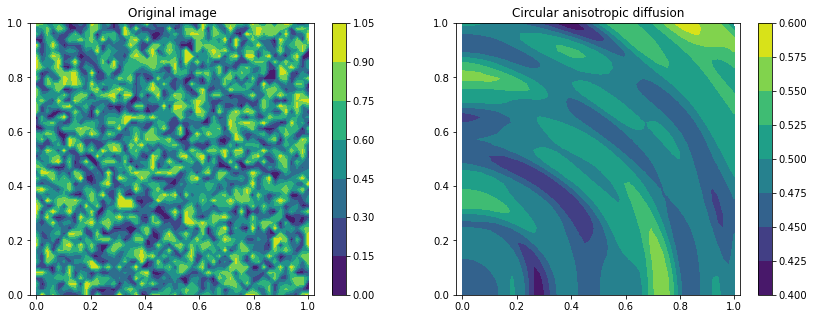

In [14]:
u0 = xp.random.rand(*shape)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.title("Original image")
plt.contourf(*X,u0)
plt.colorbar(); plt.axis('equal')

plt.subplot(1,2,2)
plt.title("Circular anisotropic diffusion")
plt.contourf(*X,evolve(u0))
plt.colorbar(); plt.axis('equal');

Circular structures are mostly preserved by the anisotropic diffusion evolution defined by our tensors `D`, since most diffusion occurs tangentially to them.

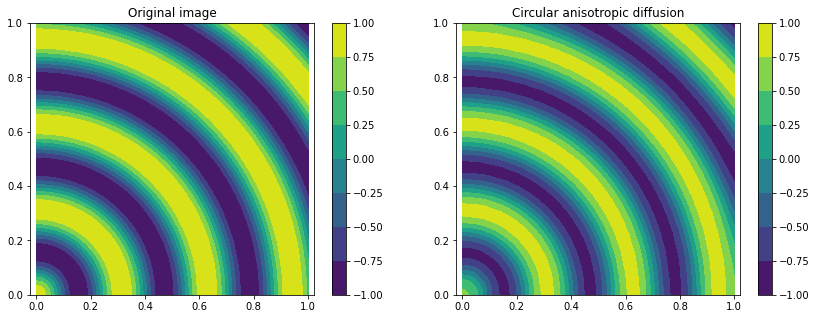

In [15]:
nX = ad.Optimization.norm(X,axis=0)
u0 = np.cos(20*nX)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.title("Original image")
plt.contourf(*X,u0)
plt.colorbar(); plt.axis('equal')

plt.subplot(1,2,2)
plt.title("Circular anisotropic diffusion")
plt.contourf(*X,evolve(u0))
plt.colorbar(); plt.axis('equal');

In contrast, radial structures are quickly blurred, again due to our choice of diffusion tensors.

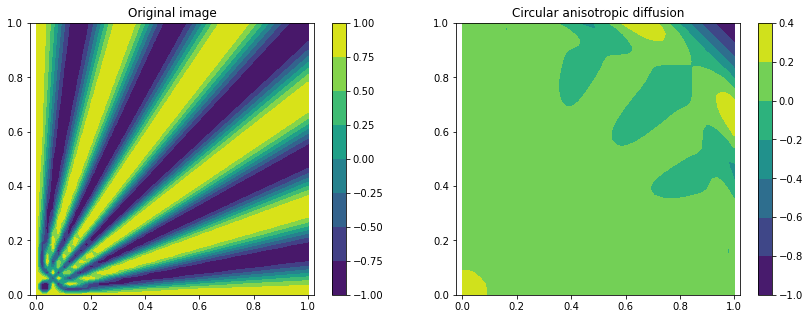

In [16]:
θ = np.arctan2(X[1],X[0])
u0 = np.cos(20*θ)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.title("Original image")
plt.contourf(*X,u0)
plt.colorbar(); plt.axis('equal')

plt.subplot(1,2,2)
plt.title("Circular anisotropic diffusion")
plt.contourf(*X,evolve(u0))
plt.colorbar(); plt.axis('equal');

## 2. Choice of diffusion tensor

In the previous section, we have shown that the effect of anisotropic diffusion dramatically depends on the choice of the diffusion tensors. In applications, the latter must be chosen so as to promote diffusion only in the places and along the directions needed.
For that purpose, a non-linear construction, depending on the processed function, must be developed. 

Let us fix the objective of using non-linear anisotropic diffusion to reinforce the image features, by smoothing tangentially to the object boundaries and to the oscillating structures. 
A preliminary step it to detect the position and orientation of these features, which is addressed as often using the structure tensor, described below. In a second step, the intensity of diffusion is adjusted, depending on the application and possibly on the taste or some artistic choice of the user. Several ad-hoc formulas have been proposed by J. Weickert to select the diffusion intensity in terms of the structure tensor eigenvalues.

In [17]:
def NonlinearDiffusion(u0,D,nO,nI,dx=1,dt=None,DiffOp=DiffusionOperator):
    """
    Perform non-linear diffusion:
    - D : map for updating the diffusion tensors
    - nI : number of inner time steps (constant diffusion tensor)
    - nO : number of outer time steps (update diffusion tensor)
    - dx (optional) : grid scale. 
    - dt (optional) : time step. Defaults to a multiple of CFL bound.
    """
    shape = u0.shape
    u = u0.copy()
    u_flat = u.reshape(-1)
    caster = ad.cupy_generic.array_float_caster(u)
    dt_as_CFL = dt is None
    for i in range(nO):
        # Produce the diffusion operator
        Du = D(u,dx) 
        Du = caster(Du) # Back to GPU and float32 if needed
        A = DiffOp(Du,dx)
        if dt_as_CFL: 
            dt = 0.3 * CFL(Du,dx)

        # Iterate diffusion
        for j in range(nI):
            u_flat -= dt*(A*u_flat)
        
    return u

In the above code, we do not use the largest possible time step, given by the CFL condition, but a substantially smaller value. Indeed, some chessboard artifacts tend to be observed otherwise in some cases, originating from the non-linearity of the scheme.

### 2.1 The structure tensor


Consider an image $u$ on a domain $\Omega$, a noise scale $\sigma$, and a feature scale $\rho$, suitably chosen or estimated. The structure tensor is defined as 
$$
    S := G_\rho \star (\nabla u_\sigma \nabla u_\sigma^T)
$$
where $G_\rho$ denotes the Gaussian kernel of width $\rho$, and where $\star$ denotes convolution. (Reflected boundary conditions are typically applied on the boundary.) We also denoted $u_\sigma := G_\sigma \star u$. 

By construction, the structure tensor is a field of positive definite matrices, whose largest eigenvector points transversally to the discontinuities and to the oscillating features of $u$.




*Question 5*
===
Construisez le tenseur de structure $S$ à partir d'une fonction $u$ et de paramètres donnés. 


In [ ]:
def StructureTensor(u,σ=2.,ρ=5.,dx=1.):
    """
    Computes the structure tensor of u,
    with noise scale σ and feature scale ρ.
    """

    # Hint : 
    - gaussian_filter(u,σ) approximates u_σ
    - gaussian_filter(u,σ,order=(1,0))/dx approximates D(u_σ)/Dx
    
    # Compute grad(uσ)
    duσ = # TODO. 
    
    # Compute S
    S = # TODO

    return S 


We illustrate the structure tensor on a function with a radial structure.

In [19]:
θ = np.arctan2(X[1],X[0])
u0 = np.cos(20*θ)

S0 = StructureTensor(u0)

The structure tensor is a feature descriptor, whose eigenvalues and eigenvectors bear geometric information. 

In [20]:
μ,v = np.linalg.eigh(np.moveaxis(S0,(0,1),(-2,-1)))

# Axes reordering and normalization
μ = np.moveaxis(μ,-1,0)
v = np.moveaxis(v,(-1,-2),(0,1))
v *= np.sign(v[0])

The eigenvector associated with the largest eigenvalue points transversally to the oscillating structures. The corresponding eigenvalue varies rather slowly, and in particular it does not oscillate at the structure scale.

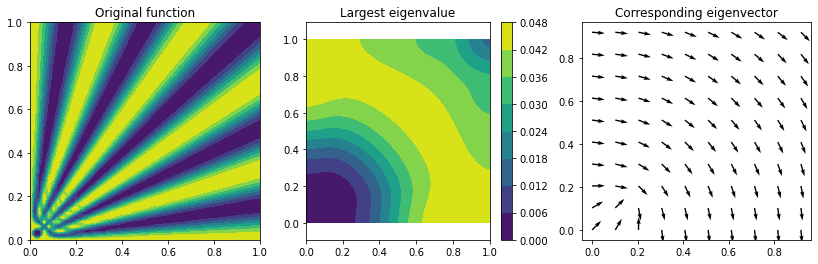

In [21]:
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.title('Original function')
plt.contourf(*X,u0)

plt.subplot(1,3,2)
plt.title('Largest eigenvalue')
plt.contourf(*X,μ[1])
plt.colorbar(); plt.axis('equal')

plt.subplot(1,3,3)
plt.title('Corresponding eigenvector')
quiver(*X,*v[:,1],subsampling=(5,5))

### 2.2 Edge enhancing diffusion

Edge enhancing diffusion aims at simplyfing an image by diffusing everywhere *except transversally to edges and oscillating structures*. It is presented by J. Weickert as an anisotropic regularization of total variation filtering.
At each point of the domain, the diffusion coefficient is $1$ in the direction tangential to the local structures (corresponding to the small eigenvalue of the structure tensor), and a smaller value in the orthogonal direction.

In [22]:
def EdgeEnhancing(μ,α=0.01,λ=1.):
    """
    Eigenvalues of the edge enhancing diffusion filter, 
    in terms of those of the structure tensor. (μ[0] <= μ[1])
    """
    ν = (μ[1] - μ[0]) / λ # Edge detector. Non-negative. 
    λ0 = np.ones_like(ν) # Unit diffusion in general
    λ1 = np.maximum(α,1.-np.exp(-3.314/ν**4)) # Small diffusion if a feature is detected
    return λ0,λ1 

Following Weickert, the diffusion tensor has the same eigenvectors as the structure tensor, but uses the mapped eigenvalues. 

Note that the diffusion tensors depend continuously on the structure tensor provided the mapping $(\mu_0, \mu_1) \mapsto (\lambda_0,\lambda_1)$ is continuous (with $\mu_0 \leq \mu_1$), *and* one has in addition
$$
    \mu_0 = \mu_1 \Rightarrow \lambda_0 = \lambda_1.
$$
Weickert's original filter, lacked this property (defining $\nu = \mu_1/\lambda$ rather than $\nu = (\mu_1 - \mu_0)/\lambda$).
Fixing it as we do here yields a mathematically well posed evolution PDE, but admitedly makes little difference in the numerical results.

In [23]:
def Du(u,dx=1.): return Riemann.from_mapped_eigenvalues(StructureTensor(u,ρ=3,dx=dx),EdgeEnhancing).m

In order to illustrate the long term effect of edge enhancing diffusion, we apply it for 3000 time steps. The diffusion tensor is updated every 10 time steps. 
The output of the non-linear diffusion evolution is stricklingly differs from the usual linear isotropic diffusion, and is akin to total variation filtering : 
* A non-smooth function ! This is due to the non-linearity; and it can be interpreted in terms of 'negative' diffusion if laplacian operator is put in non-divergence form.
* A piecewise constant function ! In this example, the output of the evolution equation is almost constant in a small circle in the center, as well as outside a larger circle.
* An almost discontinuous function ! The slope of the transition layer between the flat regions is very strong. 

This behavior is referred to as the staircaising effect, and is usually regarded as an undesirable artifact as far as applications are concerned. This effect is common in non-linear isotropic diffusion filtering, but fortunately non-linear anisotropic diffusion offers enough degrees of freedom to avoid it usually. 

Note that the maximal height of the function $u$ decreases as time increases, it become a single constant (over the whole domain) in finite time. See J. Weickert's book referenced in the introduction for more details and further references.

In [24]:
aX,dx = xp.linspace(-1,1,retstep=True)
X = ad.array(np.meshgrid(aX,aX,indexing='ij')) 
u0 = 2*np.exp( - 4*(X**2).sum(axis=0))

In [25]:
u1 = NonlinearDiffusion(u0,Du,100,10,dx)
u2 = NonlinearDiffusion(u1,Du,100,10,dx) 
u3 = NonlinearDiffusion(u2,Du,100,10,dx) 

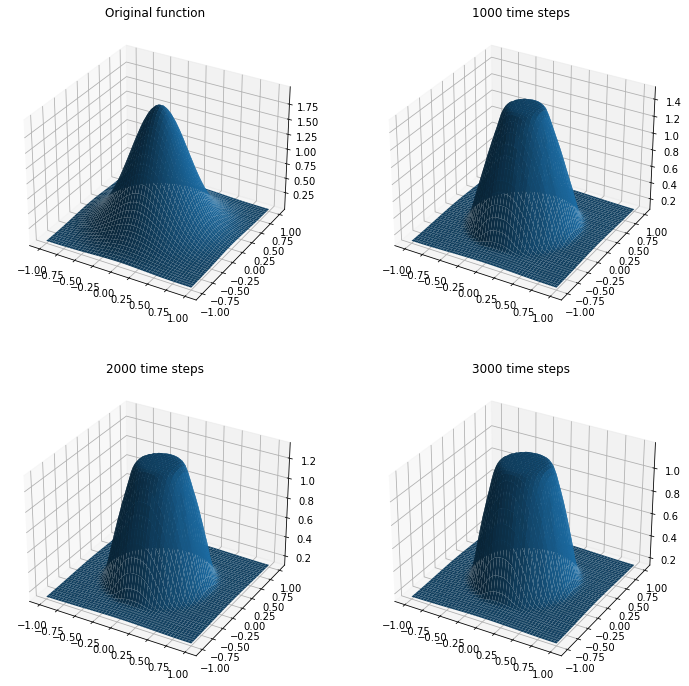

In [26]:
X, u0,u1,u2,u3 = map(ad.cupy_generic.cupy_get,(X, u0,u1,u2,u3)) # Back to CPU if needed

plt.figure(figsize=(12,12))

ax = plt.subplot(2,2,1,projection='3d')
plt.title('Original function')
ax.plot_surface(*X,u0)

ax = plt.subplot(2,2,2,projection='3d')
plt.title('1000 time steps')
ax.plot_surface(*X,u1)

ax = plt.subplot(2,2,3,projection='3d')
plt.title('2000 time steps')
ax.plot_surface(*X,u2)

ax = plt.subplot(2,2,4,projection='3d')
plt.title('3000 time steps')
ax.plot_surface(*X,u3);

*Note on GPU acceleration.* Our GPU implementation of anisotropic diffusion is too partial to be really useful, since the diffusion tensor construction is on the CPU. We drop it from this point and go CPU only.

### 2.3 Coherence enhancing diffusion

Coherence enhancing diffusion diffuses strongly along the image discontinuities or its oscillating features, and weakly elsewhere. In particular, and in contrast to edge enhancing diffusion, the smooth regions of the image remain largely untouched.

In [27]:
def CoherenceEnhancing(μ,α=0.01,λ=1.):
    """
    Eigenvalues of the edge enhancing diffusion filter, 
    in terms of those of the structure tensor. (μ[0] <= μ[1])
    """    
    ν = (μ[1] - μ[0]) / λ # Edge detector. Non-negative. 
    λ0 = α + (1-α) * np.exp(-3.314/ν**4) # Unit diffusion along features
    λ1 = α * np.ones_like(ν) # Small diffusion in general
    return λ0,λ1 

In [28]:
def Du(u,dx=1.):
    return Riemann.from_mapped_eigenvalues(StructureTensor(u,ρ=3,dx=dx),CoherenceEnhancing).m

For illustration, we apply coherence enhancing diffusion on a piecewise smooth image with added noise. As desired, the discontinuities are essentially preserved, rather than blurred, and the noise is removed.

In [29]:
aX,dx = np.linspace(0,1,100,retstep=True)
X = np.array(np.meshgrid(aX,aX,indexing='ij')) 

Ω1 = 0.3 >= np.sqrt((X[0]-0.5)**2+(X[1]-0.6)**2)
Ω2 = np.logical_and(np.logical_and(X[0]>=0.15, X[0]+6*X[1]<=1.5),X[1]>=0.1)
u0ref = 0.5*(Ω1 + Ω2)*(1.5+np.sin(6*(X[0]+2*X[1])))
u0 = u0ref + np.random.rand(*Ω1.shape)

In [30]:
u1 = NonlinearDiffusion(u0,Du,10,10,dx) 

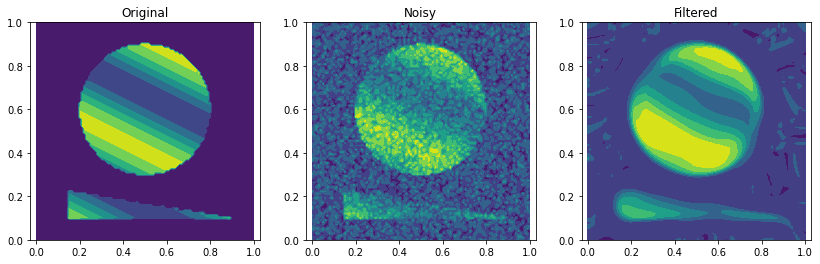

In [31]:
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.contourf(*X,u0ref)
plt.title('Original'); plt.axis('equal')

plt.subplot(1,3,2)
plt.contourf(*X,u0)
plt.title('Noisy'); plt.axis('equal')

plt.subplot(1,3,3)
plt.contourf(*X,u1)
plt.title('Filtered'); plt.axis('equal');

## 3. Application to image processing

### 3.1 Fingerprint line enhancement

A fingerprint image is filled with oscillating patterns. In this context, edge enhancing diffusion removes noise without blurring the fingerprint lines. 

In [32]:
# https://www.netclipart.com/isee/wTowwJ_black-white-cartoon-drawings-how-to-draw-a/
local_path = 'TestData/EdgeEnhancingDiffusion2D_TestImage.png'
web_path = 'https://github.com/Mirebeau/AdaptiveGridDiscretizations/blob/master/Notebooks_Div/TestData/EdgeEnhancingDiffusion2D_TestImage.png?raw=true'

try: image0 = matplotlib.image.imread(local_path)
except FileNotFoundError: image0 = matplotlib.image.imread(web_path)

In [33]:
def Du(u,dx=1.): return Riemann.from_mapped_eigenvalues(StructureTensor(u,dx=dx),EdgeEnhancing).m
u1 = NonlinearDiffusion(image0,Du,3,7,dx) 

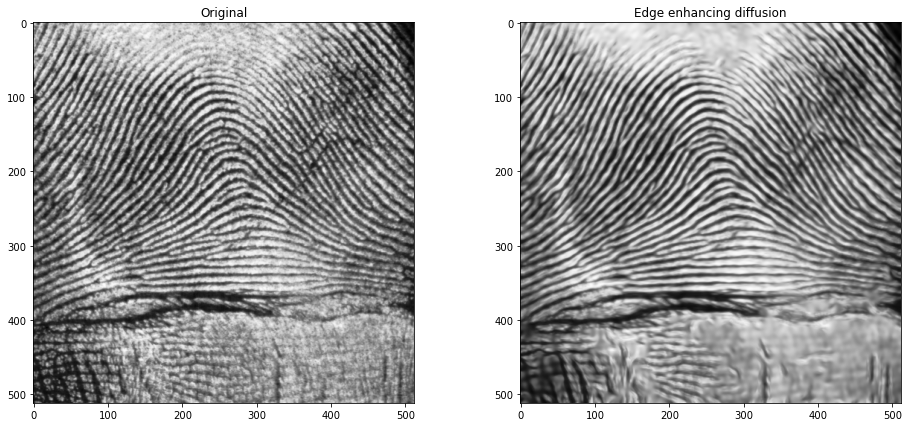

In [34]:
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
plt.imshow(image0,cmap='Greys')
plt.title('Original')

plt.subplot(1,2,2)
plt.imshow(u1,cmap='Greys')
plt.title('Edge enhancing diffusion');

### 3.2 Artistic effect

Depending on parameter setting, the edge enhancing diffusion evolution PDE may or may not amplify patterns in the noise. As a result, the method turns from a denoiser to an artistic filter.

A very noisy synthetic image with a pacman-like subject is denoised using edge enhancing diffusion.

In [40]:
# https://www.netclipart.com/isee/wTowwJ_black-white-cartoon-drawings-how-to-draw-a/
local_path = 'TestData/CoherenceEnhancingDiffusion2D_TestImage.png'
web_path = 'https://github.com/Mirebeau/AdaptiveGridDiscretizations/blob/master/Notebooks_Div/TestData/CoherenceEnhancingDiffusion2D_TestImage.png?raw=true'

try: image0 = matplotlib.image.imread(local_path)
except FileNotFoundError: image0 = matplotlib.image.imread(web_path)

In [41]:
def Du(u,dx=1.): 
    return Riemann.from_mapped_eigenvalues(StructureTensor(u,ρ=3,σ=2,dx=dx),
            lambda μ : EdgeEnhancing(μ,λ=3,α=0.1)).m
u1 = NonlinearDiffusion(image0,Du,5,5,dx) 

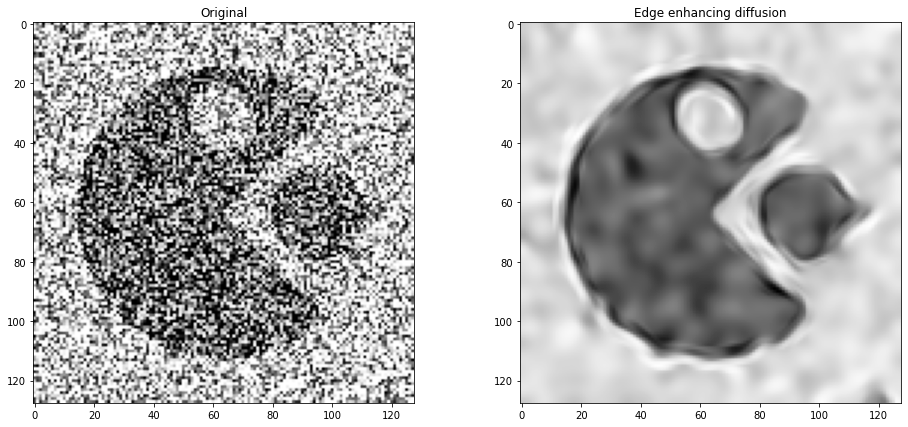

In [42]:
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
plt.imshow(image0,cmap='Greys')
plt.title('Original')

plt.subplot(1,2,2)
plt.imshow(u1,cmap='Greys')
plt.title('Edge enhancing diffusion');

Compared to the previous experiment we decrease below the noise scale $\sigma$ and feature scale $\rho$, involved in the structure tensor construction, to approximately the pixel scale. As a result, small scale noise is amplified and brush-like artistic patterns emerge. In other words, the edge enhancing diffusion generates edges out of noise with these parameters.

In [43]:
def Du(u,dx=1.): 
    return Riemann.from_mapped_eigenvalues(StructureTensor(u,ρ=1.5,σ=1.,dx=dx),
            lambda μ : EdgeEnhancing(μ,λ=3,α=0.1)).m
u1 = NonlinearDiffusion(image0,Du,5,5,dx) 

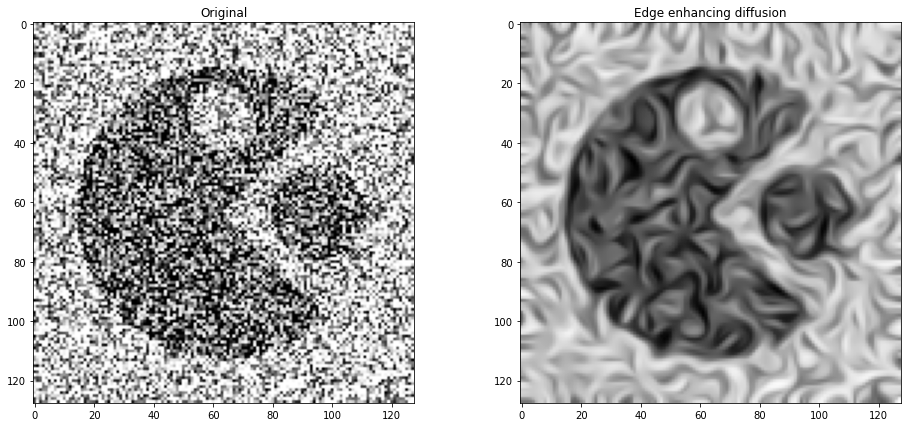

In [44]:
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
plt.imshow(image0,cmap='Greys')
plt.title('Original')

plt.subplot(1,2,2)
plt.imshow(u1,cmap='Greys')
plt.title('Edge enhancing diffusion');

### 3.3 Denoising

The ascent image, below, displays fine parallel structures. Edge enhancing diffusion (EED) is able to preserve most of them, while removing some of the synthetically added noise. The result is not perfect, as EED tends to replace the some of the noise with large scale structures which are clearly visible. A better tuning of the coefficients, or a variant of the diffusion tensors construction, may improve the results.

In [45]:
def Du(u,dx=1.): 
    return Riemann.from_mapped_eigenvalues(StructureTensor(u,ρ=2.5,σ=2,dx=dx),
            lambda μ : EdgeEnhancing(μ,λ=0.2,α=0.05)).m

image0 = scipy.misc.ascent()/255
noisy = image0+0.3*np.random.rand(*image0.shape)
u1 = NonlinearDiffusion(noisy,Du,3,5,dx) 

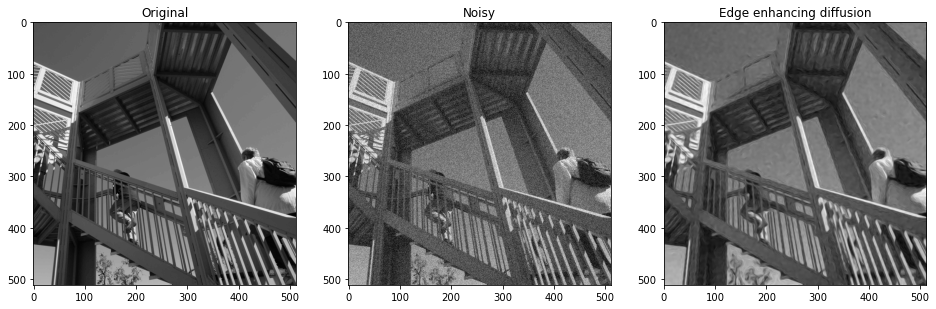

In [46]:
plt.figure(figsize=(16,7))
plt.subplot(1,3,1)
plt.imshow(image0,cmap='gray')
plt.title('Original')

plt.subplot(1,3,2)
plt.imshow(noisy,cmap='gray')
plt.title('Noisy')

plt.subplot(1,3,3)
plt.imshow(u1,cmap='gray')
plt.title('Edge enhancing diffusion');

### 3.4 Color image

Weickert's filters apply channel by channel to a color image, coupled only through the structure tensor.
Here we 'enhance' the fur texture on a racoon face.

In [47]:
image0 = np.moveaxis(scipy.misc.face()/255,-1,0)
image0 = image0[:,::2,::2] # Subsample

In [48]:
image0.shape

(3, 384, 512)

In [49]:
def Du(u,dx=1.): 
    # Sum the three structure tensor channels
    S = sum(StructureTensor(ui,ρ=1.5,σ=1,dx=dx) for ui in u)
    # Same as usual
    return Riemann.from_mapped_eigenvalues(S, lambda μ : EdgeEnhancing(μ,λ=0.2,α=0.05)).m

def DiffusionOperatorRGB(D,dx):
    A = DiffusionOperator(D,dx)
    class Op:
        def __mul__(self,u):
            # Apply diffusion channel by channel
            return np.array([A*ui for ui in u.reshape(3,-1)]).reshape(-1)
    return Op()

In [50]:
u1 = NonlinearDiffusion(image0,Du,5,5,dx,DiffOp=DiffusionOperatorRGB) 

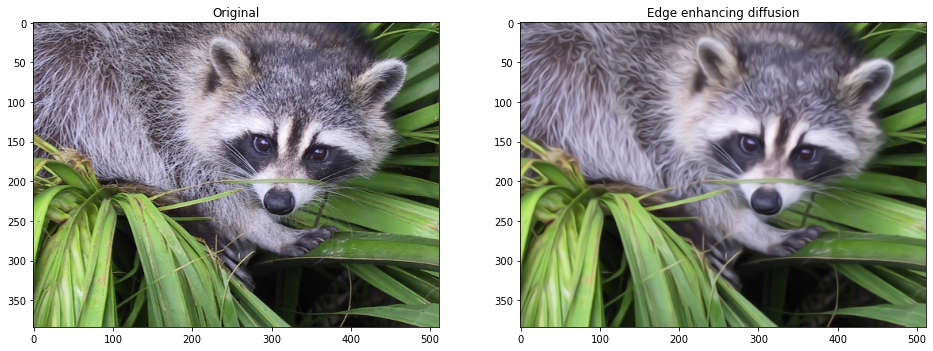

In [51]:
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
plt.imshow(np.moveaxis(image0,0,-1))
plt.title('Original')

plt.subplot(1,2,2)
plt.imshow(np.moveaxis(u1,0,-1))
plt.title('Edge enhancing diffusion');